In [1]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
from keras.models import Sequential
import keras.layers as layers
import keras
import keras.backend as K
from keras.callbacks import  TensorBoard
from numpy.random import seed
import tensorflow as tf
tf.set_random_seed(2)
seed(1)

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
'''
    * Loading the MNIST from disk.
'''
DATA_DIR = 'MNIST/'

trainImages = idx2numpy.convert_from_file(DATA_DIR + 'train-images-idx3-ubyte')
trainLabels = idx2numpy.convert_from_file(DATA_DIR + 'train-labels-idx1-ubyte')
testImages = idx2numpy.convert_from_file (DATA_DIR + 't10k-images-idx3-ubyte')
testLabels = idx2numpy.convert_from_file (DATA_DIR + 't10k-labels-idx1-ubyte')

# Dimensions
print(trainImages.shape)
print(trainLabels.shape)
print(testImages.shape)
print(testLabels.shape)

# Lables
print(set(testLabels))

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


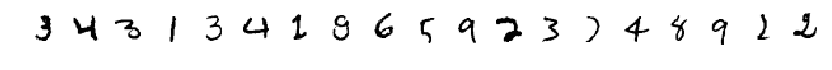

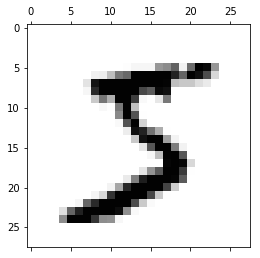

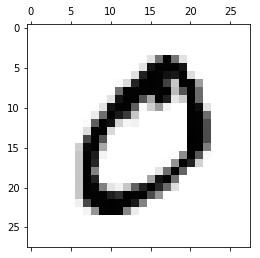

In [3]:
'''
    * Visualizing the dataset
'''
NUMBER_OF_PICTURES = 20
fig = plt.figure(figsize=(15, 15))
for i in range(1, NUMBER_OF_PICTURES):
    cell = fig.add_subplot(1, NUMBER_OF_PICTURES, i)
    cell.axis('off')
    cell.add_image(plt.imshow(trainImages[i*10], cmap='Greys'))
plt.show()

plt.matshow(trainImages[0], cmap='Greys')
plt.matshow(trainImages[1], cmap='Greys')

In [4]:
'''
    * Reshaping data to match the conv2d layer.
'''
train_x = trainImages.reshape(len(trainImages), 28, 28, 1)
train_y_onehot = keras.utils.to_categorical(trainLabels, num_classes=10)
test_x = testImages.reshape(len(testImages), 28, 28, 1)
test_y_onehot = keras.utils.to_categorical(testLabels, num_classes=10)


''' a tiny dataset to test the model correctness '''
#small_data = small_data.reshape(len(small), 28, 28, 1)
#small_labels_one_hot = keras.utils.to_categorical(trainLabels[0:12], num_classes=10)
#model.fit(small_data, small_labels_one_hot, epochs=12)

print(train_x.shape)
print(train_y_onehot.shape)

(60000, 28, 28, 1)
(60000, 10)


In [5]:
'''
    Send train_x and train_y
    * Building and Fitting the model.
'''
# passing the layers in a list instead of the bloody .add() 

arch_1 = [layers.Conv2D(filters=20, # Numbers of kernals/Filters
            kernel_size=(3,3), # Filter size
            activation='relu',
            padding='same', 
            input_shape=(28, 28, 1)), # Dimensions of one data point (row * hieght * channels)
          layers.MaxPooling2D(pool_size=(10, 10), padding='valid'),
          layers.Conv2D(filters=10, 
                kernel_size=(3,3), 
                activation='relu',
                padding='same'), 
          layers.MaxPooling2D(pool_size=(2, 2), padding='valid'),
          layers.Flatten(), # Flatting the last output as [K * 1 Vector]
          layers.Dense(units=10, activation='softmax') # Fully Connected Layer of 10 units (10 weights and biases)
         ]

In [6]:
model = Sequential(arch_1)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
#model.fit(train_x, train_y_onehot, epochs=1, validation_split=2.0, batch_size=1024)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 20)        200       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 20)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 10)          1810      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 10)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
Total params: 2,120
Trainable params: 2,120
Non-trainable params: 0
_________________________________________________________________


In [7]:
'''
    * fit_generator: using Sequence class.
'''

class BatchGenerator(keras.utils.Sequence):
    
    def __init__(self, batch_size,
                 train_x, 
                 train_y_onehot):
        self.train_x = train_x
        self.train_y_onehot = train_y_onehot
        self.batch_size = batch_size
    
    def __len__(self):
        return int(np.ceil(len(self.train_x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.train_x[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.train_y_onehot[idx * self.batch_size : (idx + 1) * self.batch_size]
        return batch_x, batch_y


model_2 = Sequential(arch_1)
train_sequence = BatchGenerator(1024, train_x, train_y_onehot)
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_2.summary()
#model_2.fit_generator(generator=train_sequence, epochs = 1, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 20)        200       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 20)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 10)          1810      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 10)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
Total params: 2,120
Trainable params: 2,120
Non-trainable params: 0
_________________________________________________________________


In [8]:
'''
    * 2 customized loss function
    * Cross Entropy takes lables and softmax vector.
'''
y_lables = np.array([1, 0,  1,   1,   1])
y_hat    = np.array([1, 0, 0.9, 0.5, 0.1])

model_3 = Sequential(arch_1)
# the cost function 
def cross_entropy_total_cost(y_lables, y_hat):
#clipped_log_1 = tf.clip_by_value(tf.log(y_hat), clip_value_max=1e+10, clip_value_min=-1e+10)
#clipped_log_0 = tf.clip_by_value(tf.log(1 - y_hat), clip_value_max=1e+10, clip_value_min=-1e+10)
#return - tf.reduce_mean(tf.reduce_sum(y_lables * clipped_log_1 + (1-y_lables) * clipped_log_0))

#clipped_log_1 = K.clip(K.log(y_hat),     min_value=-1e+10, max_value=1e+10)
#clipped_log_0 = K.clip(K.log(1 - y_hat), min_value=-1e+10, max_value=1e+10)
#losses = -y_lables * clipped_log_1 + (1-y_lables) * clipped_log_0
#cross = K.mean(K.sum(losses))
#return cross

#    return - K.mean(K.sum(y_lables* tf.log(y_hat), axis=1))

#    clipped_log = tf.clip_by_value(tf.log(y_hat), clip_value_min=-1e+10, clip_value_max=1e+10)
#    return -tf.reduce_mean(tf.reduce_sum(y_lables * clipped_log, reduction_indices=1))

#    clipped_log = tf.clip_by_value(tf.log(y_hat), clip_value_min=-1e+10, clip_value_max=1e+10)
#    return -tf.reduce_mean(tf.reduce_sum(y_lables * clipped_log, reduction_indices=1))

#     return -tf.reduce_mean(tf.reduce_sum(y_lables * tf.log(y_hat), reduction_indices=1))
#+1e-9
    clipped_logit = tf.clip_by_value(tf.log(y_hat+1e-9), clip_value_min=-1e+10, clip_value_max=1e+10)
    return -tf.reduce_mean(tf.reduce_sum(y_lables * clipped_logit, reduction_indices=1))

#'categorical_crossentropy'
model_3.compile(loss=cross_entropy_total_cost, optimizer='adam', metrics=['accuracy'])
model_3.summary()
model_3.fit(train_x, train_y_onehot, epochs=1, validation_split=2.0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 20)        200       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 20)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 10)          1810      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 10)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
Total params: 2,120
Trainable params: 2,120
Non-trainable params: 0
_________________________________________________________________
Epoch 1/

In [9]:
logits = np.array([
    [0.9, 0.1],
    [0.8, 0.2],
    [0.4, 0.7]
])

labels = np.array([
    [1, 0],
    [1, 0],
    [0, 1]
])

- np.mean(np.sum(labels * np.log(logits), axis=1))

0.22839300363692283

In [ ]:
'''NumPy Version'''
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

# two observations
predictions = np.array([[0.25,0.25,0.25,0.25],
                        [0.01,0.01,0.01,0.96]])
# two lables
targets = np.array([[0,0,0,1],
                   [0,0,0,1]])
cross_entropy(logits, labels)

In [ ]:
'''TensorFlow Version'''
logits = np.array([
    [1.0, 0.0],
    [0.8, 0.2],
    [0.4, 0.7]
])

labels = np.array([
    [1, 0],
    [1, 0],
    [0, 1]
])

logits_tensor = tf.Variable(logits, dtype=tf.float32)
labels_tensor = tf.Variable(labels, dtype=tf.float32)

# np.mean(np.sum(labels * np.log(logits), axis=1))
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    clipped_logit = sess.run(tf.clip_by_value(tf.log(logits+1e-9), clip_value_min=-1e+10, clip_value_max=1e+10))
    loss = sess.run(-tf.reduce_mean(tf.reduce_sum(labels_tensor * clipped_logit, reduction_indices=1)))
    print(loss)

In [ ]:
# تهبيد
y_hat_value    = np.array([1,  0,  0.9,  0.5,  0.1])
y_lables_value = np.array([1,  0,    1,    1,    1])
y_labels_value_categories = keras.utils.to_categorical(y_lables_value)
y_lables_argmax = K.argmax(y_labels_value_categories)

#y_lables = tf.placeholder(dtype=tf.float32, shape=(5, None))
#y_hat = tf.placeholder(dtype=tf.float32, shape=(5, None))

y_lables = tf.Variable(y_lables_value, dtype=tf.float32)
y_hat = tf.Variable(y_hat_value, dtype=tf.float32)

clipped_log_1 = K.clip(K.log(y_hat),     min_value=-1e+10, max_value=1e+10)
clipped_log_0 = K.clip(K.log(1 - y_hat), min_value=-1e+10, max_value=1e+10)
losses = -y_lables * clipped_log_1 + (1-y_lables) * clipped_log_0
cross = K.mean(K.sum(losses))

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init) ###
    out1 = sess.run(losses)
    out2 = sess.run(cross)
    out3 = keras.utils.to_categorical(y_lables_value)
    out4 = sess.run(K.argmax(y_labels_value_categories) )
    print(out1)
    print(out2)
    print(out3)
    print(out4)

In [ ]:
# تهبيد
labels * np.log(logits) + (labels - 1) * np.log(1-logits)

In [ ]:
'''
    * LeNet
'''

In [ ]:
'''
    * ResNet
'''